In [1]:
import zipfile
from glob import glob
import os
from netCDF4 import Dataset
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import requests
import time

import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

2023-02-27 09:13:18.202424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 09:13:18.412197: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.11.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11185071897516780065
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23342153728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12875057524242236738
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23342153728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15012627666451297235
physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6"
xla_global_id: 2144165316
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 23342153728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11571011749800854475
physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6"
xla_global_id: 1651660799
, name: "/d

2023-02-27 09:13:20.294921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 09:13:22.666740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 22260 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2023-02-27 09:13:22.668141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:1 with 22260 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-02-27 09:13:22.668916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:2 with 22260 MB memory:  -> device: 2, name: NVIDIA GeForce RT

In [2]:
path = '/home/workspace'
data_path = os.path.join(path,'cmaqProjectdata')
proj_path = os.path.join(path,'repos','cmaqProject')

In [3]:
train_tfr_path = glob(os.path.join(data_path,"dataset_record","train",'*.tfr'))
test_tfr_path = glob(os.path.join(data_path,"dataset_record","test",'*.tfr'))


print("trainset_n: ", len(train_tfr_path), "valset_n: ", "testset_n: ", len(test_tfr_path))

trainset_n:  5 valset_n:  testset_n:  2


In [4]:
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_ver_8_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_prefix

'/home/workspace/repos/cmaqProject/models/training_checkpoints/model_ver_8_checkpoint/ckpt'

In [5]:
path_data_newrecord = os.path.join(data_path, "dataset_record_airpol_asos_20132022")
oob_record_list = glob(os.path.join(path_data_newrecord, "*.tfr"))
oob_record_list[:3]

['/home/workspace/cmaqProjectdata/dataset_record_airpol_asos_20132022/dataset_asos_airpol_2015.tfr',
 '/home/workspace/cmaqProjectdata/dataset_record_airpol_asos_20132022/dataset_asos_airpol_2019.tfr',
 '/home/workspace/cmaqProjectdata/dataset_record_airpol_asos_20132022/dataset_asos_airpol_2013.tfr']

In [6]:
BATCH_SIZE = 32
EPOCH = 1
shuffle_buffer_size = 100
# N_RUN = 1000

input_width = 6
target_width = 1
window_size = input_width + target_width
shift = 1

In [7]:
#################### CHECK !! ######################
####################################################
#인풋채널수 잘 확인

INPUT_SHAPE = [input_width, 64, 64, 16]
OUTPUT_CHANNELS = 1

## 데이터셋 생성

* 학습-검증셋 준비

In [8]:
def _parse_function2(tfrecord_serialized):
    features={
        'CMAQ_t': tf.io.FixedLenFeature([], tf.string),
        'SMOKE_t': tf.io.FixedLenFeature([], tf.string),
        'air_quality_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'weather_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        # 'year': tf.io.FixedLenFeature([], tf.string),
        # 'month': tf.io.FixedLenFeature([], tf.string),
        # 'day': tf.io.FixedLenFeature([], tf.string),
        # 'hour': tf.io.FixedLenFeature([], tf.string),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    cmaq = tf.io.decode_raw(parsed_features['CMAQ_t'], tf.float32)
    # 12년 측정망자료로 나중에 정규화 해주기
    smoke = tf.io.decode_raw(parsed_features['SMOKE_t'], tf.float32)
    aq = tf.io.decode_raw(parsed_features['air_quality_monitoring_t'], tf.float64)  #이것 둘 64로 저장됨
    # 바람 방향 x, y벡터랑 강도로 뽑는작업 나중에 하기
    weather = tf.io.decode_raw(parsed_features['weather_monitoring_t'], tf.float64)
    # year = tf.io.decode_raw(parsed_features['year'], tf.uint8)
    # 월 sin함수 주기로 바꾸어서 넣어주기
    # month = tf.io.decode_raw(parsed_features['month'], tf.uint8)
    # 일 sin함수 주기로 바꾸어서 넣어주기
    # day = tf.io.decode_raw(parsed_features['day'], tf.uint8)
    # hour = tf.io.decode_raw(parsed_features['hour'], tf.uint8)

  

    cmaq = tf.reshape(cmaq, [82, 67, 1])
    # print(cmaq.shape)
    smoke = tf.reshape(smoke, [82, 67, 45])
    # print(smoke.shape)
    aq = tf.reshape(aq, [82, 67, 1])
    # # print(aq.shape)
    weather = tf.reshape(weather, [82, 67, 15])
    # print(weather.shape)
    
    # year = tf.squeeze(year)
    # month = tf.squeeze(month)
    # day = tf.squeeze(day)
    # hour = tf.squeeze(hour)

    
    # image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    # image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])


    # classes = tf.io.decode_raw(parsed_features['classes'], tf.uint8)    
    # classes = tf.squeeze(classes)
    # tf.cast(cmaq,tf.float32)
    # tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=3)
    # tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:]
    # return cmaq[8:-10,2:-1,:], tf.cast(smoke,tf.float32)[8:-10,2:-1,:], year, month, day, hour
    # return smoke[8:-10,2:-1,:],cmaq[8:-10,2:-1,:]
    # return smoke,cmaq
    # return tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:], cmaq[8:-10,2:-1,:]
    return tf.concat([tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:], cmaq[8:-10,2:-1,:]

In [9]:


def get_target_window(x1,x2):
    return x2.batch(window_size, drop_remainder=True)

def get_input_window(x1,x2):
    return x1.batch(window_size, drop_remainder=True)

def dense_step_input(input_batch):
  # Shift features and labels one step relative to each other.
  return input_batch[:-1]

def dense_step_target(target_batch):
  # Shift features and labels one step relative to each other.
  return target_batch[-1]

In [10]:
# 학습셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
train_dataset = tf.data.TFRecordDataset(train_tfr_path)
train_dataset = train_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)

train_dataset_cmaq = train_dataset.flat_map(get_target_window)
train_target = train_dataset_cmaq.map(dense_step_target)

train_dataset_smoke = train_dataset.flat_map(get_input_window)
train_input = train_dataset_smoke.map(dense_step_input)

train_ds = tf.data.Dataset.zip((train_input, train_target)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)

2023-02-27 09:31:34.989460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22260 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2023-02-27 09:31:34.989693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22260 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-02-27 09:31:34.989895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22260 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2023-02-27 09:31:34.990094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21743 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

In [11]:
# 검증셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
test_dataset = tf.data.TFRecordDataset(test_tfr_path)
test_dataset = test_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)

test_dataset_cmaq = test_dataset.flat_map(get_target_window)
test_target = test_dataset_cmaq.map(dense_step_target)

test_dataset_smoke = test_dataset.flat_map(get_input_window)
test_input = test_dataset_smoke.map(dense_step_input)

test_ds = tf.data.Dataset.zip((test_input, test_target)).batch(BATCH_SIZE)

## 모델 학습

In [12]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():

  inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

  initializer_1 = tf.random_normal_initializer(0., 0.02)
  conv_lstm2d = tf.keras.layers.ConvLSTM2D(32, kernel_size=3, padding='same', return_sequences=False, kernel_initializer=initializer_1)
  batch_norm_1 = tf.keras.layers.BatchNormalization()
  relu_1 = tf.keras.layers.ReLU()

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  x = conv_lstm2d(x)
  
  x = batch_norm_1(x)
  x = relu_1(x)
  
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [14]:
def Discriminator():
  conv_lstm2d = tf.keras.layers.ConvLSTM2D(1, kernel_size=3, padding='same', return_sequences=False, )
  
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=INPUT_SHAPE, name='input_image')
  tar = tf.keras.layers.Input(shape=[64, 64,1], name='target_image')

  inp_1 = conv_lstm2d(inp)

  print(inp_1)
  print(tar)

  x = tf.keras.layers.concatenate([inp_1, tar])  # (batch_size, 256, 256, channels*2)
  print(x)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
  print(last)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [15]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [16]:
## 저장된 모델 불러오기
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

generator = Generator()
discriminator = Discriminator()

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), name='conv_lstm2d_1/strided_slice_2:0', description="created by layer 'conv_lstm2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='target_image'), name='target_image', description="created by layer 'target_image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 2), dtype=tf.float32, name=None), name='concatenate_4/concat:0', description="created by layer 'concatenate_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 1), dtype=tf.float32, name=None), name='conv2d_8/BiasAdd:0', description="created by layer 'conv2d_8'")


In [17]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  display_list = [test_input[0][0][:,:,:3], tar[0][:,:,0][::-1], prediction[0][::-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [18]:
for batch in test_ds.take(1):
    print(1)

1


2023-02-27 09:31:40.937494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


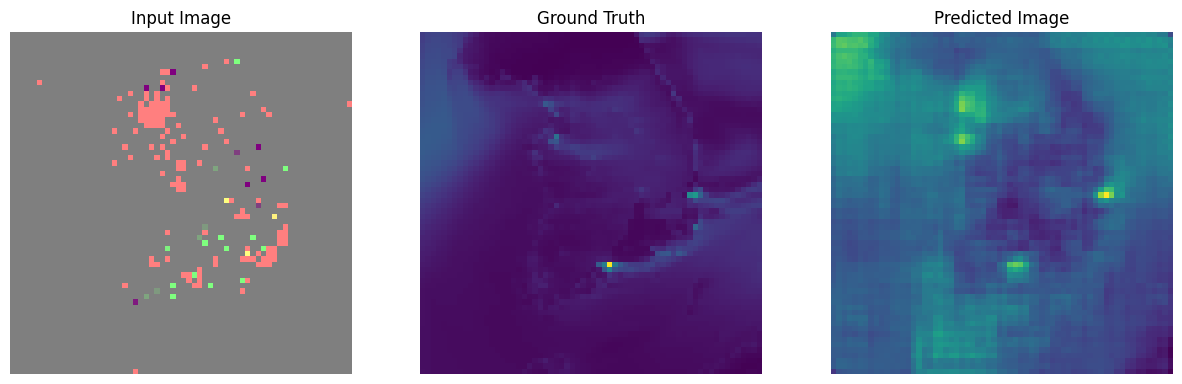

In [19]:
generate_images(generator, batch[0][0:1], batch[1][0:1])

* 학습

In [20]:
import datetime
summary_writer = tf.summary.create_file_writer(os.path.join(checkpoint_prefix, "logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [21]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
    tf.summary.scalar('disc_loss', disc_loss, step=step)

In [22]:
from IPython import display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken for 20 steps: 2.43 sec



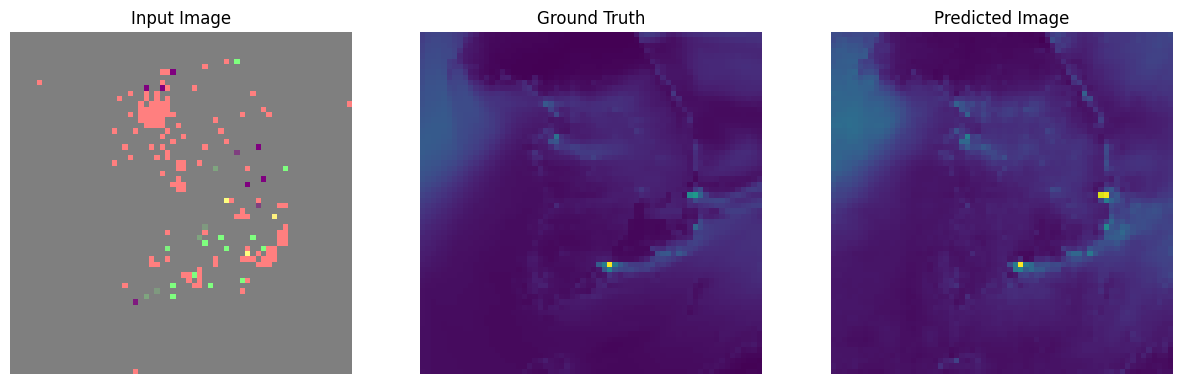

Step: 49980
..CPU times: user 4h 29min 10s, sys: 41min 26s, total: 5h 10min 36s
Wall time: 1h 44min 49s


In [23]:
%%time

steps = 50000

example_input, example_target = next(iter(test_ds.take(1)))
start = time.time()

for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
  if (step) % 20 == 0:
    display.clear_output(wait=True)

    if step != 0:
      print(f'Time taken for 20 steps: {time.time()-start:.2f} sec\n')

    start = time.time()

    generate_images(generator, example_input, example_target)
    print(f"Step: {step}")

  train_step(input_image, target, step)

  # Training step
  if (step+1) % 10 == 0:
    print('.', end='', flush=True)


  # Save (checkpoint) the model every 5k steps
  if (step + 1) % 1000 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

2023-02-27 11:16:33.742721: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


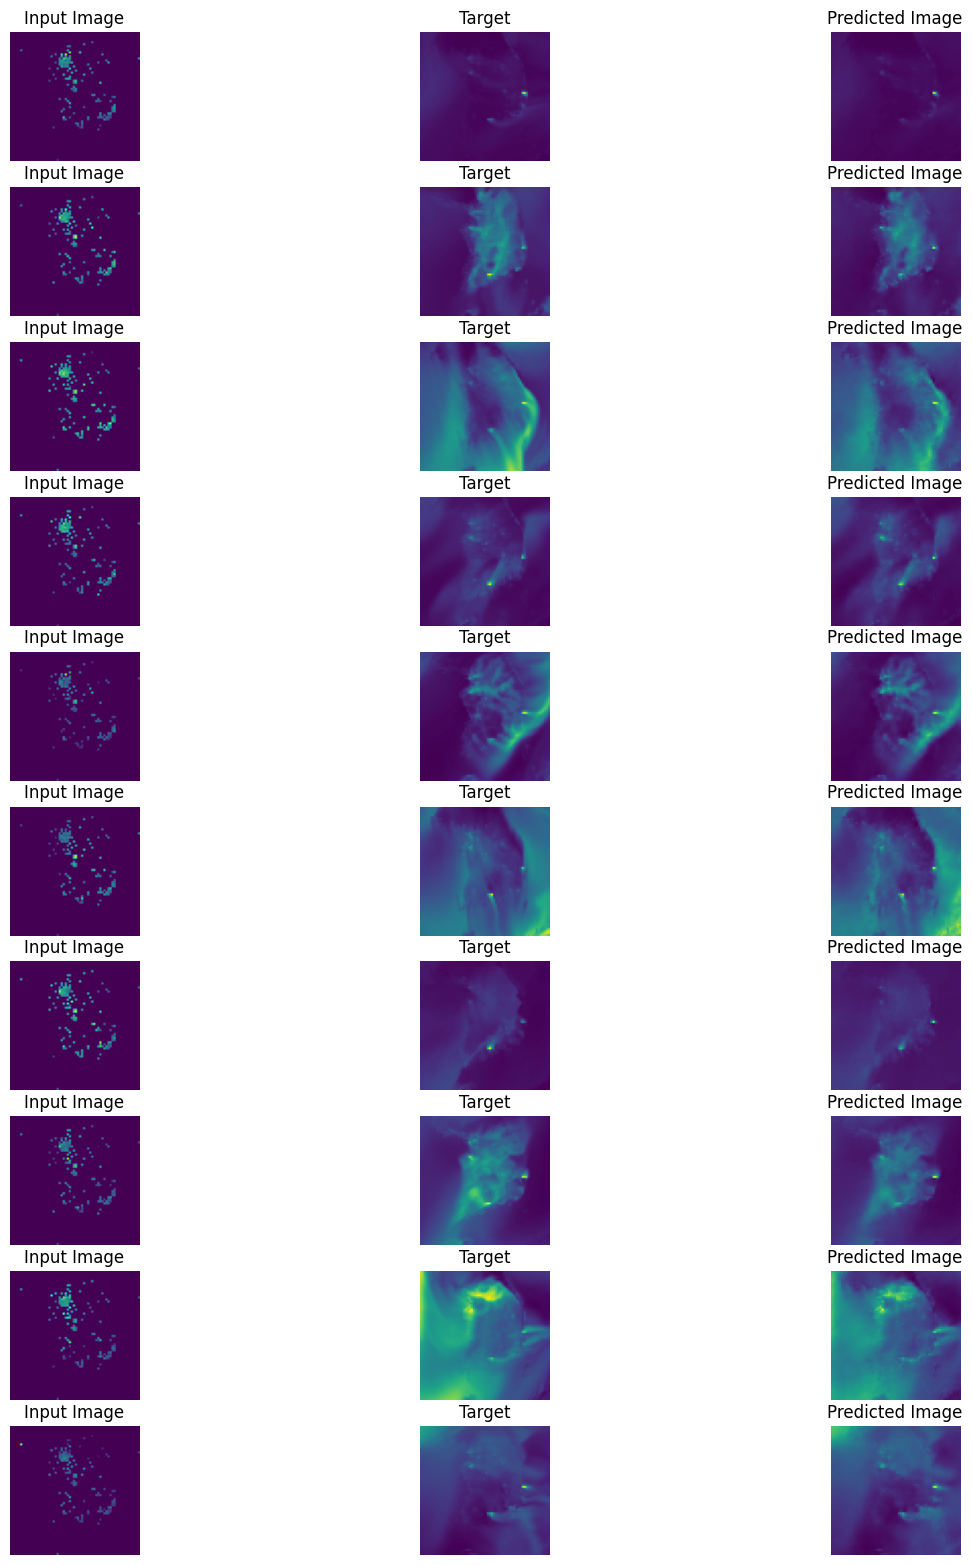

In [24]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in test_ds.repeat().take(10).enumerate():
  prediction = generator(input_image, training=True)
  
  display_list = [input_image[3][0][:,:,0], target[3][:,:,0][::-1], prediction[3][:,:,0][::-1]]
  title = ['Input Image','Target', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  j += 3

## 모니터링자료 예측해보기

In [25]:
def _parse_function3(tfrecord_serialized):
    features={
        'air_quality_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'weather_monitoring_t': tf.io.FixedLenFeature([], tf.string),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
   
    aq = tf.io.decode_raw(parsed_features['air_quality_monitoring_t'], tf.float64)  #이것 둘 64로 저장됨
    # 바람 방향 x, y벡터랑 강도로 뽑는작업 나중에 하기
    weather = tf.io.decode_raw(parsed_features['weather_monitoring_t'], tf.float64)
    
    aq = tf.reshape(aq, [82, 67, 1])
    # # print(aq.shape)
    weather = tf.reshape(weather, [82, 67, 15])
    # return smoke,cmaq
    # return tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:], cmaq[8:-10,2:-1,:]
    return tf.concat([tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:]

In [26]:
def get_oob_input_window(x1):
    return x1.batch(window_size, drop_remainder=True)

def dense_step_input(input_batch):
  # Shift features and labels one step relative to each other.
  return input_batch[:-1]


def oob_target(window_batch):
  # Shift features and labels one step relative to each other.
  return window_batch[-1]

In [27]:
# 검증셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
oob_test_dataset = tf.data.TFRecordDataset(oob_record_list[0])
oob_test_dataset = oob_test_dataset.map(_parse_function3, num_parallel_calls=tf.data.experimental.AUTOTUNE)
oob_test_dataset = oob_test_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)

oob_test_dataset_smoke = oob_test_dataset.flat_map(get_oob_input_window)
oob_test_input = oob_test_dataset_smoke.map(dense_step_input)

oob_test_target = oob_test_dataset_smoke.map(oob_target)

# oob_test_ds = tf.data.Dataset.zip((oob_test_input, oob_test_target)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
oob_test_ds = tf.data.Dataset.zip((oob_test_input, oob_test_target)).batch(BATCH_SIZE)

2023-02-27 11:16:38.270346: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


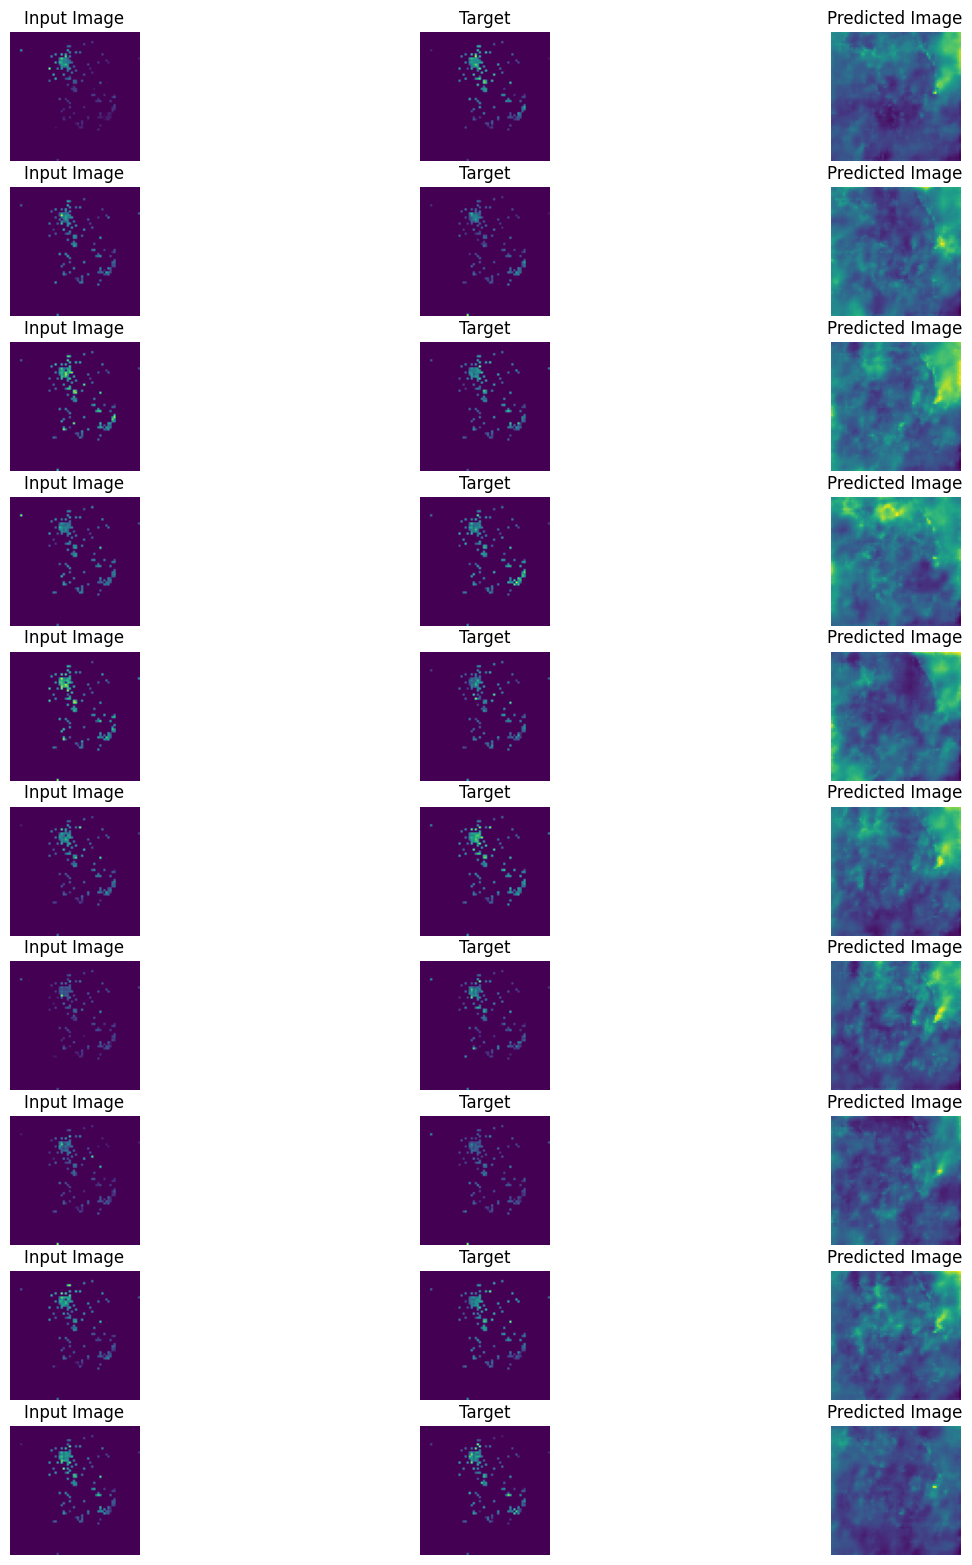

In [28]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in oob_test_ds.repeat().take(10).enumerate():
  prediction = generator(input_image, training=True)
  
  display_list = [input_image[3][0][:,:,0], target[3][:,:,0], prediction[3][:,:,0][::-1]]
  title = ['Input Image','Target', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  j += 3

2023-02-27 11:16:41.545324: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


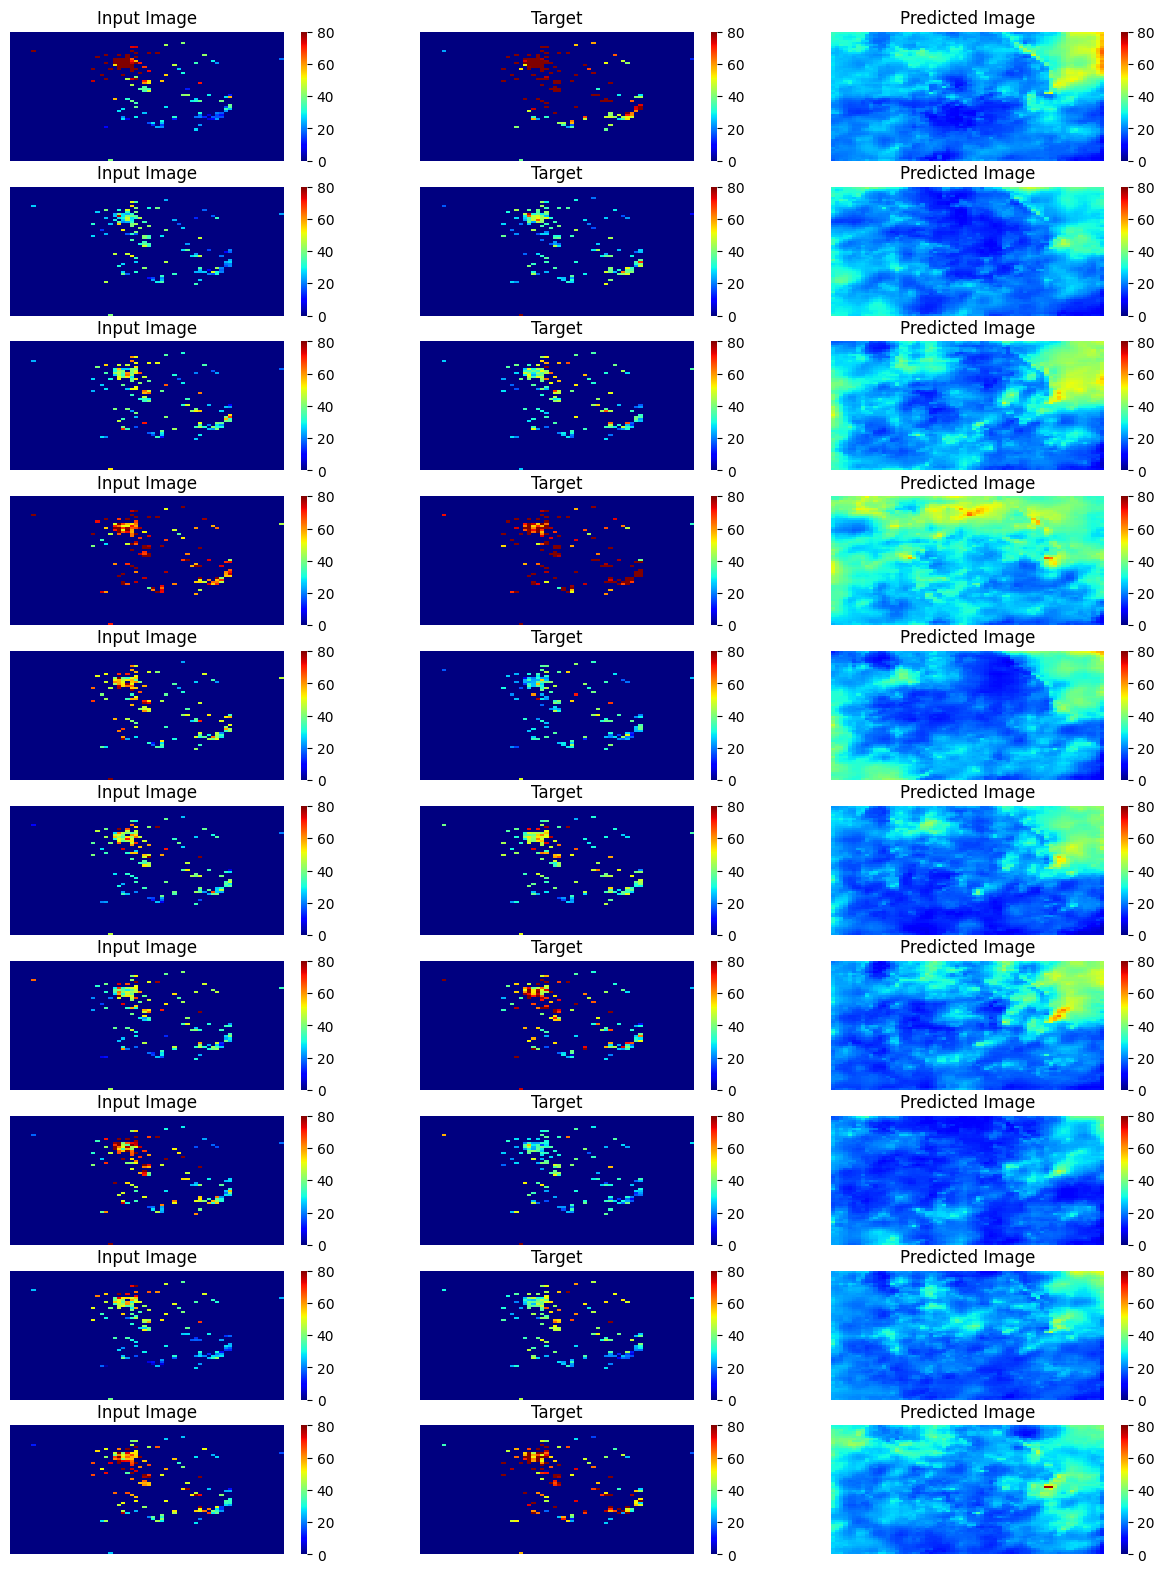

In [29]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in oob_test_ds.repeat().take(10).enumerate():
  prediction = generator(input_image, training=True)
  
  display_list = [input_image[3][0][:,:,0], target[3][:,:,0], prediction[3][:,:,0][::-1]]
  title = ['Input Image','Target', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    sns.heatmap(display_list[i], cmap='jet', vmin=0, vmax=80)
    plt.axis('off')
  j += 3